<a href="https://colab.research.google.com/github/kleberga/proj_classificacao/blob/main/proj_classificacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **1. Certificado de conclusão do módulo "Kaggle Intro to Machine Learning":**

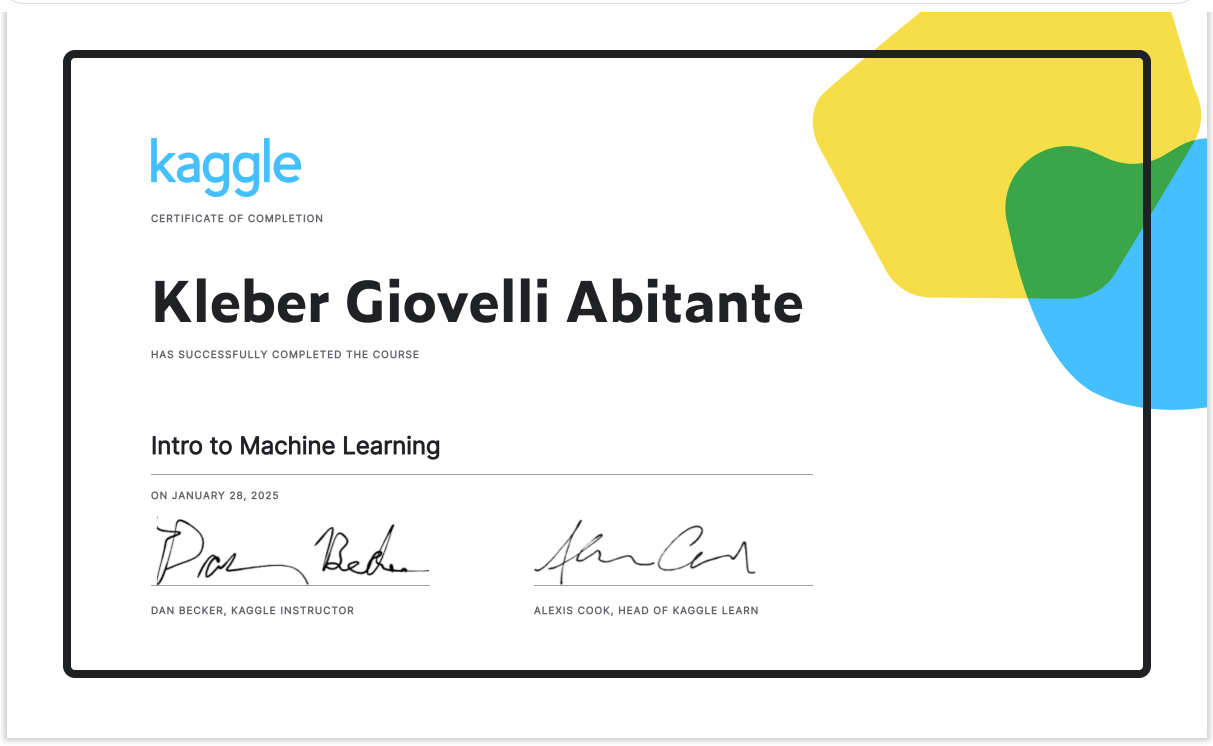

#### **2. Download da base de dados:**

In [72]:
# importar as bibliotecas necessárias
import urllib.request
import zipfile
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, make_scorer, accuracy_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from tabulate import tabulate
import numpy as np
import warnings
import matplotlib.pyplot as plt
import math

In [73]:
# remover os warnings
warnings.filterwarnings("ignore")

In [74]:
# definir a URL que contém o arquivo ZIP com os dados
url = "http://www3.dsi.uminho.pt/pcortez/wine/winequality.zip"

# definir o arquivo ZIP que será baixado por meio da URL
zip_arq = "winequality.zip"

# nome do arquivo de vinho branco
wine_white = "winequality/winequality-white.csv"

# baixar o arquivo ZIP
urllib.request.urlretrieve(url, zip_arq)

# extrair o CSV de dentro do arquivo ZIP
with zipfile.ZipFile(zip_arq, 'r') as zip_ref:
    zip_ref.extract(wine_white)

# carregar o arquivo
white = pd.read_csv(wine_white, sep=";")

#### **3. Descrição das variáveis presentes na base:**

In [75]:
# extrair os nomes das colunas e converter em lista
white_var = white.columns.tolist()

# criar um dataframe de nomes
white_var_df = pd.DataFrame(white_var, columns=["Nome das variáveis"])

# capturar os tipos das variáveis e transformar em lista
white_type = white.dtypes.tolist()

# inserir no dataframe
white_var_df["Tipo"] = white_type

# calcular a media das variaveis
white_mean = white.mean().tolist()

# inserir no dataframe
white_var_df["Média"] = white_mean

# calcular o desvio padrão das variáveis
white_std = white.std().tolist()

# inserir no dataframe
white_var_df["Desvio padrão"] = white_std

# verificar se há missing values
white_missing = white.isnull().sum().tolist()

# inserir no dataframe
white_var_df["Nr. de missing values"] = white_missing

# contar a quantidade de observações
white_count = white.count().tolist()

# inserir no dataframe
white_var_df["Nr. de observações"] = white_count

**Tabela 1 - Descrição das variáveis da tabela de vinhos brancos**

In [76]:
white_var_df

Nome das variáveis     Tipo  ...  Nr. de missing values  Nr. de observações
0          fixed acidity  float64  ...                      0                4898
1       volatile acidity  float64  ...                      0                4898
2            citric acid  float64  ...                      0                4898
3         residual sugar  float64  ...                      0                4898
4              chlorides  float64  ...                      0                4898
5    free sulfur dioxide  float64  ...                      0                4898
6   total sulfur dioxide  float64  ...                      0                4898
7                density  float64  ...                      0                4898
8                     pH  float64  ...                      0                4898
9              sulphates  float64  ...                      0                4898
10               alcohol  float64  ...                      0                4898
11               quality    int64  ...                      0                4898

[12 rows x 6 columns]

#### **4. Com a base escolhida:**

**a. Descrição das etapas necessárias para criar um modelo de classificação eficiente.**

Em primeiro lugar, deve-se identificar a variável *target* (ou dependente) e as variáveis que acredita-se serem relevantes para classificação da *target* (variáveis explicativas ou *features*). Esse processo pode ser auxiliado por pessoas que tenham conhecimento e/ou experiência sobre o problema que será modelado e, assim, indiquem as variáveis relevantes a serem utilizadas, bem como a forma de obtenção das mesmas.

Em se tratando da base de dados de vinhos brancos, a Tabela 1 apresenta os nomes das variáveis selecionadas para o modelo de classificação, bem como uma breve descrição das mesmas, como tipo e estatísticas descritivas (média e desvio padrão). Deve-se verificar se alguma variável foi importada como caracter ("string"), pois o modelo aceita apenas variáveis numéricas. Se isto ocorreu, a variável deve ser convertida para número. Na tabela citada, a coluna "Tipo" indica que todas variáveis são numéricas (float64 ou int64).

No presente estudo, a variável *target* será a variável "opinion", que ainda será criada a partir da variável "quality". As demais variáveis, exceto "quality", são potenciais variáveis explicativas.

Complementando a análise dos dados, deve-se pesquisar se existem valores faltando nos dados (*missing values*). Em caso positivo, deve-se decidir se estes registros devem ser excluídos ou utiliza-se algum método para estimar e preencher os valores que estão faltando. A coluna "Nr. de missing values" da Tabela 1 mostra a quantidade de valores faltando em cada variável, permitindo concluir que não há valores faltando na base. Por fim, a coluna "Nr. de observações" informa que há 4.898 observações de cada variável.

Em seguida, a fim de facilitar a utilização das variáveis, os espaços existentes nos nomes das mesmas serão substituídos por *underline* (_), conforme o código a seguir:

In [77]:
# substituir o nome das variáveis por underline
white.columns = white.columns.str.replace(" ","_")

Ainda na etapa de verificação e preparação da base de dados, deve-se criar a variável *target* do modelo de classificação. Essa variável será do tipo categórica, chamada "opinion", e assumirá valor 0 (zero) se "quality" por menor ou igual a 5 (cinco) e 1 (um) caso contrário. O código a seguir cria essa variável e elimina a variável "quality":

In [78]:
# criar a variável target "opinion"
white['opinion'] = white['quality'].apply(lambda x: 0 if x <= 5 else 1)

# eliminar a variável 'quality' da base
white.drop('quality', axis=1, inplace=True)

Como a variável *target* é uma variável categórica, é importante verificar se esta variável está balanceada na base de dados, ou seja, se a proporção de observações com valor 0 (zero) e 1 (um) não é muito discrepante a ponto de ser necessário utilizar algum método para balancear a base. A tabela a seguir mostra a proporção dos valores.

In [79]:
# calcular a quantidade de zero e uns da variável "opinion"
value_counts = white['opinion'].value_counts(normalize=True)

# converter a tabela em DataFrame
value_counts_df = value_counts.reset_index()

# renomear as colunas
value_counts_df.columns = ['Valor da variável "opinion"', "Proporção de observações"]

**Tabela 2 - Proporção dos valores 0 (zero) e 1 (um) da variável "opinion" na base de dados**

In [80]:
value_counts_df

Valor da variável "opinion"  Proporção de observações
0                            1                  0.665169
1                            0                  0.334831

A Tabela 2 mostra que cerca de 67% de observações da variável "opinion" possuem valor 1 (um) e cerca de 33% possuem valor 0 (zero). Trata-se, portanto, de uma base desbalanceada. Na pesquisa pelos melhores hiperparâmetros dos modelo, será considerado o hiperparâmetro *class_weight* que ajusta os pesos das variáveis de forma inversamente proporcional a sua frequência nos dados.

A próxima etapa do processo de modelagem consiste em verificar se há separabilidade linear entre a variável "target" e cada uma das variáveis explicativas. Este procedimento tem por objetivo verificar se há variáveis explicativas que conseguem gerar uma reta separando perfeitamente os valores 0 (zero) e 1 (um) da variável "opinion". Em caso positivo, essas variáveis seriam grandes candidatas a serem utilizadas no modelo de classificação, pois podem ajudar a melhorar o seu resultado.

A figura a seguir mostra os gráficos de dispersão da combinação dois a dois das variáveis explicativas. As cores dos pontos representam os valores 0 (zero) ou 1 (um) da variável "opinion". Para que houvesse separabilidade linear, deveria ser possível traçar uma reta separando perfeitamente os pontos azuis e vermelhos. Como isso não ocorre, não há separabilidade linear nas combinações dois a dois.

**Figura 1 - Avaliação da separabilidade linear entre a variável "target" e as variáveis explicativas**

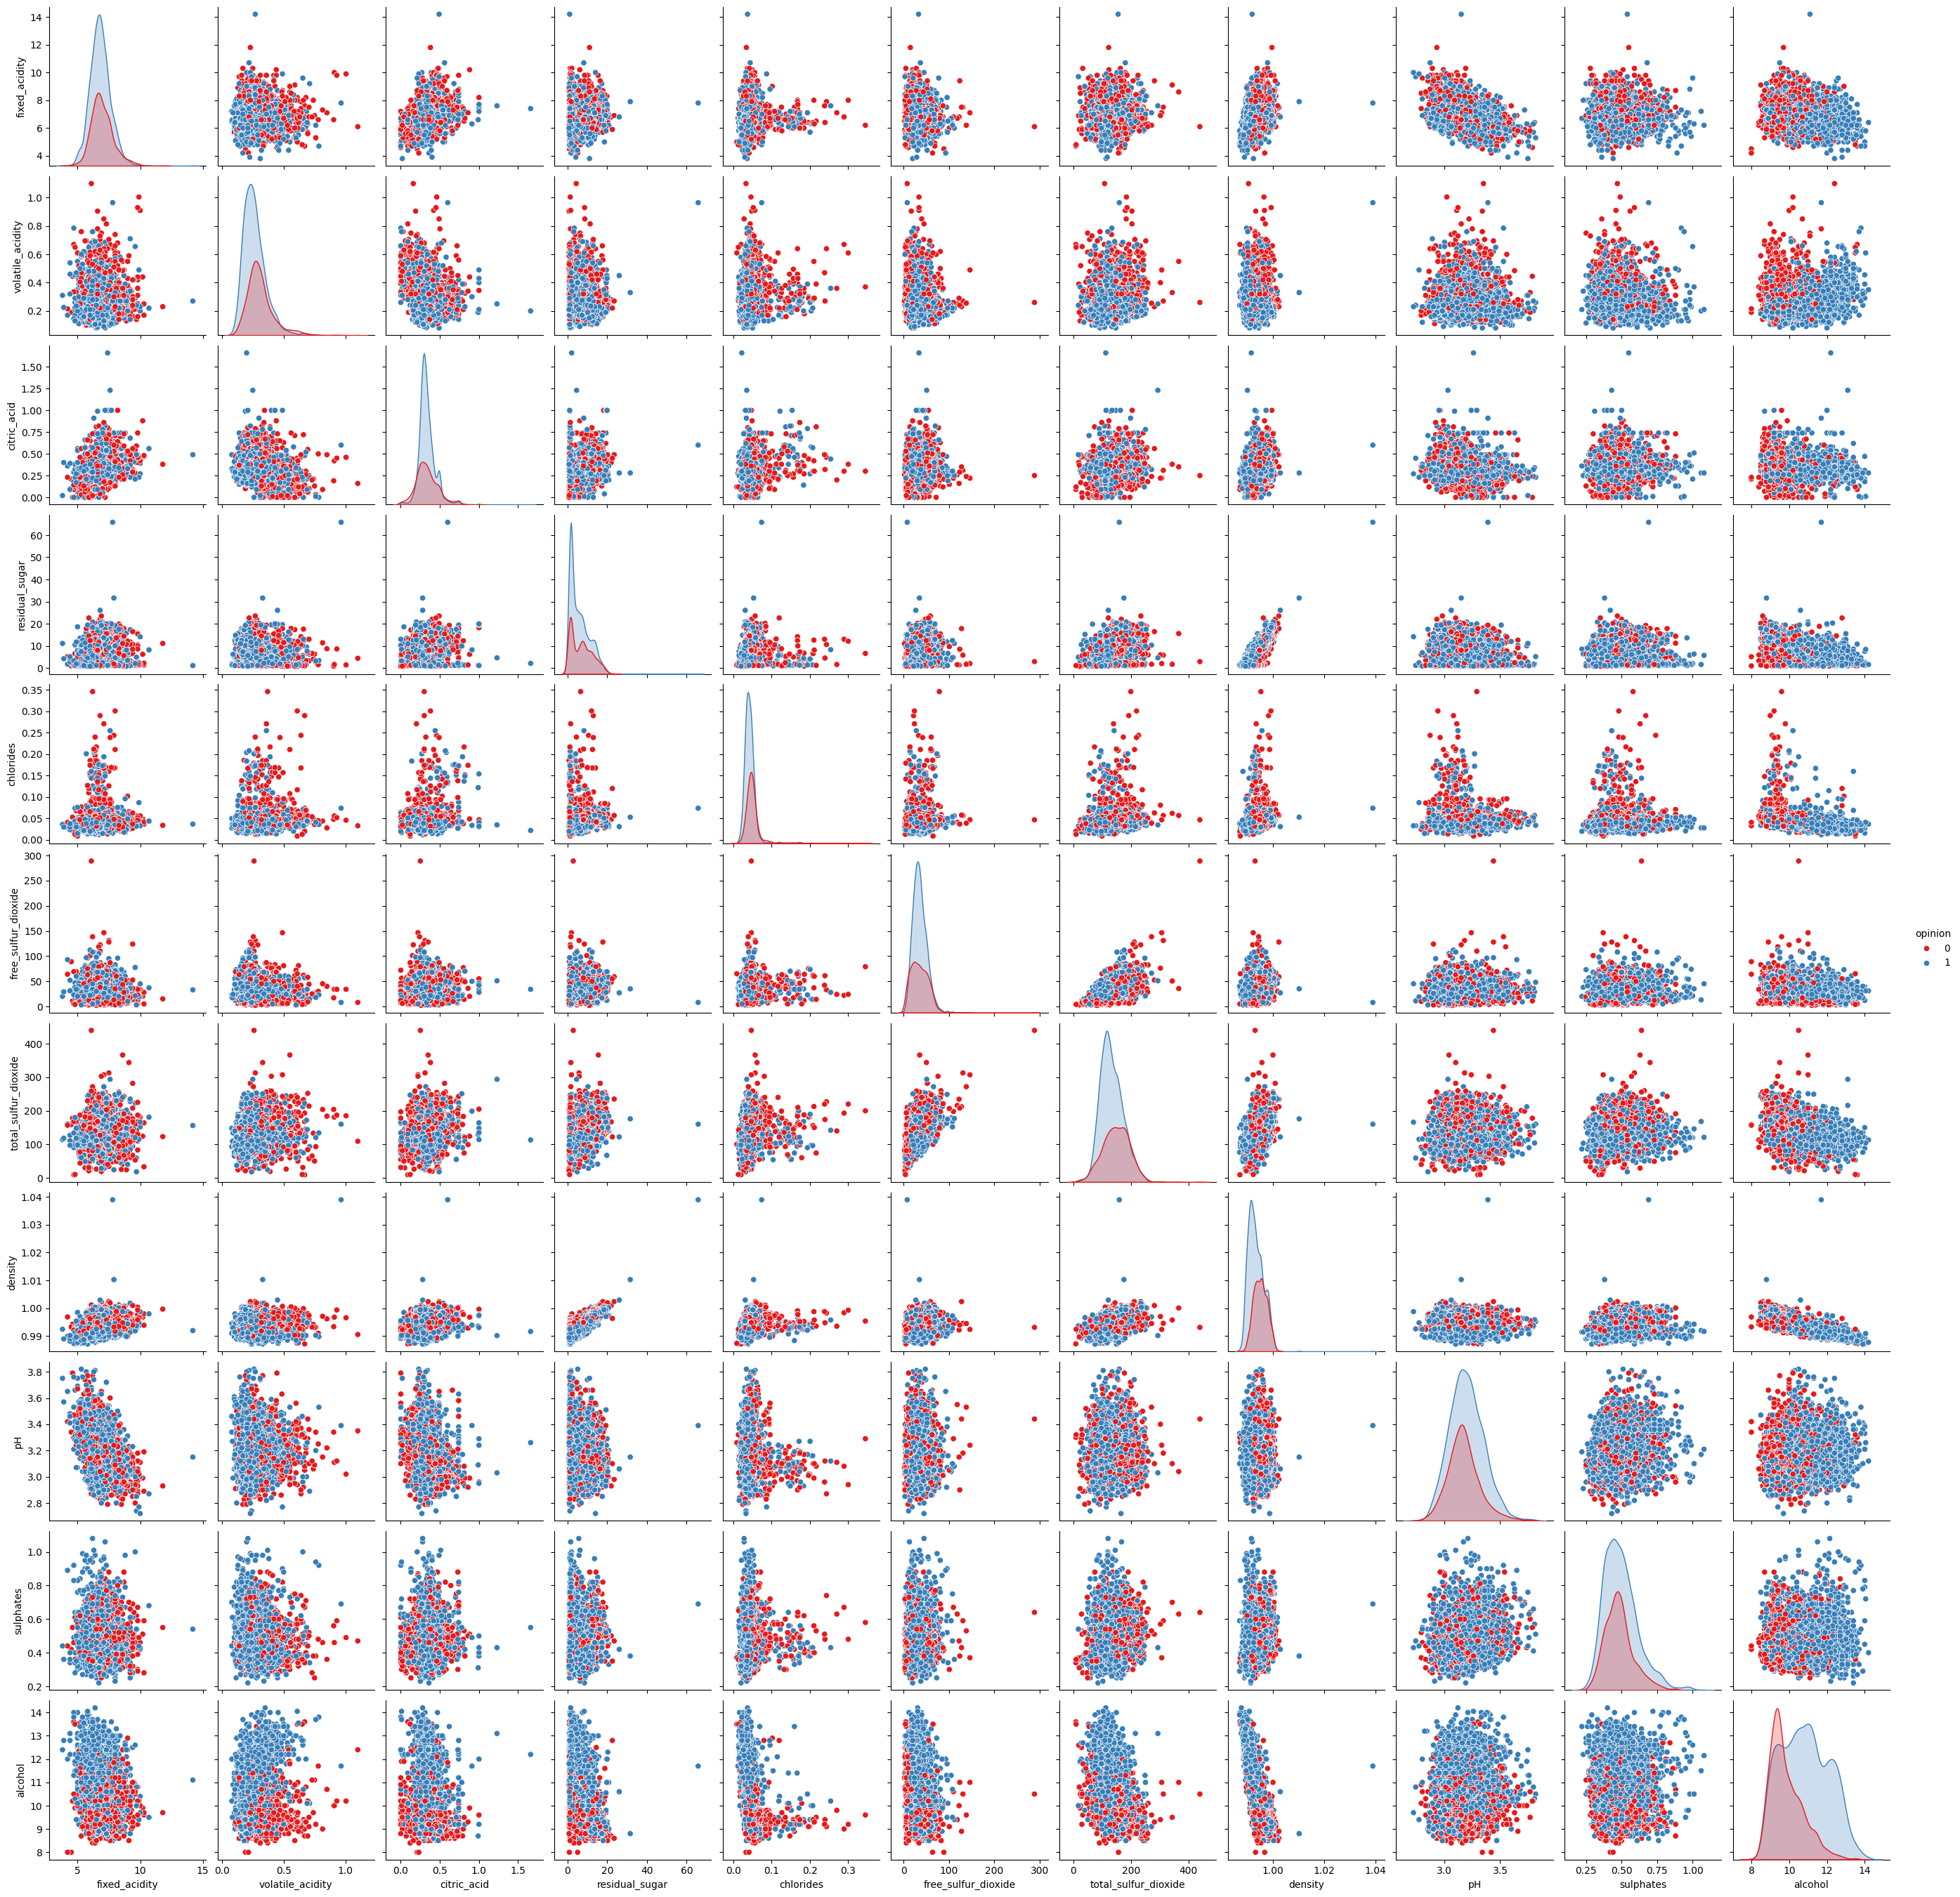

In [81]:
sns.pairplot(white, hue="opinion", palette="Set1")

Contudo, apesar de não haver separabilidade linear nas no universo bidimensional, isso não inviabiliza a utilização das variáveis escolhidas, pois pode ocorrer a separabilidade em dimensões superiores. Portanto, a criação do modelo pode prosseguir.

A próxima etapa consiste em separar a base de dados em duas: uma de treinamento e outra de teste. A base de treinamento, como o próprio nome diz, será usada para treinar o modelo. Em seguida, iremos verificar a capacidade de classificação do modelo aplicando o mesmo na base de teste. Ao aplicar o modelo em dados que não foram utilizados para treiná-lo, é possível avaliar o modelo como se o mesmo estivesse em produção, recebendo novos dados dos usuários. O código a seguir irá separar a variável "target" e as variáveis explicativas. Em seguida, as duas bases será divididas em bases de treino e teste, mantendo a proporção de 0 (zero) e 1 (um) da variável "opinion" (amostragem estratificada).

In [82]:
# criar a tabela apenas com as variáveis explicativas
x = white.drop(columns=['opinion'])
y = white['opinion']

# dividir a base em treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=10, stratify=y)

# verificar as proporções de zero e um nas bases de treino e teste
prop_train = pd.Series(y_train).value_counts(normalize=True)
prop_teste = pd.Series(y_test).value_counts(normalize=True)

# criar um DataFrame com as proporções de treino
prop_train_df = pd.DataFrame({
    "Valor": prop_train.index,
    "Proporção": prop_train.values
})

# criar um DataFrame com as proporções de teste
prop_teste_df = pd.DataFrame({
    "Valor": prop_teste.index,
    "Proporção": prop_teste.values
})

# unir as duas tabelas
merged_df = pd.merge(prop_train_df, prop_teste_df, on="Valor", suffixes=("_treino", "_teste"))

**Tabela 3 - Proporção de zero e um das bases de treino e teste**

In [83]:
merged_df

Valor  Proporção_treino  Proporção_teste
0      1          0.665111         0.665306
1      0          0.334889         0.334694

A Tabela 3 mostra que as proporções de 0 (zero) e 1 (um) nas bases de treino e teste são muito próximas, permitindo o treinamento e teste do modelo de forma adequada.

Ainda no âmbito do pré-processamento dos dados, deve-se avaliar se existe muita discrepância na escala das variáveis explicativas. Em caso positivo, as variações nas variáveis que possuem maior escala irão apresentar maior influência na variável "target" em relação às variáveis com menor escala. A tabela a seguir mostra os cinco primeiros exemplos das variáveis de teste, a fim de se avaliar as escala das variáveis.

**Tabela 4 - Amostra dos cinco primeiros exemplos de teste**

In [84]:
# mostrar os cinco primeiros registros das variáveis explicativas
x_train.head()

fixed_acidity  volatile_acidity  citric_acid  ...    pH  sulphates  alcohol
1297            7.3              0.42         0.38  ...  3.19       0.37     12.6
774             9.1              0.27         0.45  ...  3.20       0.46     10.4
8               6.3              0.30         0.34  ...  3.30       0.49      9.5
4524            6.6              0.16         0.25  ...  3.16       0.38     10.0
816             8.4              0.18         0.42  ...  3.16       0.52     11.7

[5 rows x 11 columns]

A tabela anterior indica que existe uma diferença de escala importante da variável "total_sulfur_dioxide", em relação às demais, uma vez que esta variável está em centenas de unidades e as demais são menores que a unidade ou entre um e dez unidades. Neste cenário, de diferença de escalas, optou-se por realizar o escalonamento das variáveis explicativas utilizando a padronização robusta, a qual é menos sensível à existência de outliers nos dados. Este escalonamento será realizado no momento do treinamento de cada modelo.

**b. Treinar um modelo de regressão logística**

Na próxima etapa, foi criado um modelo de regressão logística para tentar prever a variável *target*. Para fins de comparação, foi criado um modelo *baseline*, ou seja, um modelo que será a referência, servindo de comparação para os demais modelos. Como a participação de 1 (um) nos dados é maior, o modelo *baseline* irá considerar que todos os vinhos brancos possuem a variável "opinion" igual a 1 (um). O código abaixo cria a base de dados classificando todas os vinhos branco da base de teste como tendo opinião 1 (um).

In [85]:
# criar a classificação do modelo de referência
y_referencia = np.repeat(1, repeats=len(y_test))
y_referencia

array([1, 1, 1, ..., 1, 1, 1])

A seguir, são calculadas as métricas de avaliação do modelo *baseline* e a área sob a curva ROC.

In [86]:
# métricas do baseline
print(classification_report(y_test, y_referencia))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       492
           1       0.67      1.00      0.80       978

    accuracy                           0.67      1470
   macro avg       0.33      0.50      0.40      1470
weighted avg       0.44      0.67      0.53      1470



In [234]:
# calcular a curva ROC e o AUC
fpr, tpr, thresholds = roc_curve(y_test, y_referencia)
roc_auc = auc(fpr, tpr)
roc_auc

0.5

Para fins deste estudo, optou-se por avaliar o modelo por meio da média ponderada das métricas (*weighted avg*). Além disso, como o problema de classificação em questão não demanda a preferência por uma métrica de performance em detrimento de outra, foram escolhidas as métricas *f1-score*, que representa a média harmônica da métricas *precision* e *recall*, e a área sob a curva ROC, para avaliar o desempenho dos modelos. Assim, o *f1-score* do modelo *baseline* é de 0,53 e a área sob a curva ROC é de 0.5.

Para identificar os hiperparâmetros da regressão logística, foi utilizado o seguinte procedimento:
- primeiro, o método da pesquisa aleatória, a fim de identificar os intervalos dos hiperparâmetros em que há maior chance de que estejam os melhores hiperparâmetros. Foi definida a quantidade de 200 amostras, a fim de manter adequada relação entre qualidade da solução e tempo de processamento; e
- em seguida, o método de pesquisa bruta para verificar, na região indicada pela pesquisa aleatória, os melhores valores para os hiperparâmetros.

Foram escolhidos cinco hiperparâmetros para serem objeto de busca:  
- *'penalty'*, que consiste em um hiperparâmetro que previne *overfitting* ao adicionar um valor à função custo em caso de coeficientes com valores muito altos. Os valores de busca foram *None*, 'l2', 'l1' e 'elasticnet';
- *'C'*, que é o parâmetro que controla da força da regularização. Os valores de busca foram 0.001, 0.01, 0.1, 1 e 20;
- *'l1_ratio'*, que é proporção da regularização que será feita pelo *penalty* do tipo 'l1'. Os valores de busca foram 0.25, 0.5 e 0.75;
- *'class_weight'*, que é utilizado para conferir pesos diferentes para as classes. Este argumento pode melhorar a performance do modelo quando uma classe é significativamente mais frequente que a outra. Os valores de busca foram *'balanced'* e *None*; e
- *'k*: a quantidade de *features* no modelo, com intervalo de busca de 1 a 12.

Por fim, foi realizada a validação cruzada estratificada com 10 folhas, a fim de se verificar as métricas de performance em diferentes amostras de treinamento e de teste. O código a seguir implementa a avaliação proposta anteriormente, utilizando o solver 'saga' para aumentar a chance de estimação das diferentes combinações de modelos.

In [87]:
# criar o amostrador de 10 folhas com estratificação
divisor = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)

# definir métricas personalizads
scorers = {
    'recall': make_scorer(recall_score, average='weighted'),
    'precision': make_scorer(precision_score, average='weighted'),
    'accuracy': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score, average='weighted')
}

# criar um novo pipeline
reg_log1 = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('model', LogisticRegression(solver='saga'))
])

# definir o intervalo de busca
params_grid_reg_log1 = {
    'model__penalty': [None,'l2','l1','elasticnet'],
    'model__C': [0.001, 0.01, 0.1, 1, 20],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'model__class_weight': ['balanced',None],
    'selector__k': range(1,13)
}

# criar o buscador aleatório
busca_rl = RandomizedSearchCV(
    estimator=reg_log1,
    param_distributions=params_grid_reg_log1,
    n_iter=200,
    cv=divisor,
    scoring=scorers,
    refit='f1_score',
    error_score=0
)

# estimar o modelo
busca_rl.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              LogisticRegression(solver='saga'))]),
                   n_iter=200,
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 20],
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__l1_ratio': [0.25, 0....
                                        'selector__k': range(1, 13)},
                   refit='f1_score',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                            'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                            'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

O código a seguir apresenta os melhores hiperparâmetros identificados pela pesquisa bruta.

In [88]:
# identificar os melhores hiperparâmetros pela pesquisa aleatória
busca_rl.best_params_

{'selector__k': 8,
 'model__penalty': 'l1',
 'model__l1_ratio': 0.75,
 'model__class_weight': None,
 'model__C': 0.1}

Diante dos resultados da pesquisa aleatória, foi feita a pesquisa bruta dos seguintes hiperparâmetros:
- *'penalty'*, com ajuste no intervalo para None, 'l2' e 'l1';
- *'C'*: com ajuste no intervalo para 0.001, 0.01, 0.1 e 1;
- *'l1_ratio'*: mantido o intervalo usado na busca aleatória;
- *'k'*: com ajuste de busca para o intervalo de 7 a 12.  

O código abaixo realiza a pesquisa bruta.

In [89]:
# definir o intervalo de busca
params_grid_reg_log2 = {
    'model__penalty': [None,'l2','l1'],
    'model__C': [0.001, 0.01, 0.1, 1],
    'model__l1_ratio': [0.25, 0.5, 0.75],
    'selector__k': range(7,13)
}

# criar a pesquisa bruta
busca_rl2 = GridSearchCV(
    estimator=reg_log1,
    param_grid=params_grid_reg_log2,
    cv=divisor,
    scoring=scorers,
    refit='f1_score',
    error_score=0
)

# estimar o modelo
busca_rl2.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('selector', SelectKBest()),
                                       ('model',
                                        LogisticRegression(solver='saga'))]),
             param_grid={'model__C': [0.001, 0.01, 0.1, 1],
                         'model__l1_ratio': [0.25, 0.5, 0.75],
                         'model__penalty': [None, 'l2', 'l1'],
                         'selector__k': range(7, 13)},
             refit='f1_score',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

In [90]:
# identificar os melhores hiperparâmetros pela pesquisa bruta
busca_rl2.best_params_

{'model__C': 0.1,
 'model__l1_ratio': 0.25,
 'model__penalty': 'l1',
 'selector__k': 8}

Em seguida, o código extrai as métricas obtidas na validação cruzada do modelo com os melhores hiperparâmetros e o resultado é mostrado na Tabela 5.

In [91]:
# identificar os melhores hiperparâmetros
best_index_reg_log1 = busca_rl2.best_index_

# capturar a média do modelo com os melhores hiperparâmetros
mean_test_accuracy_rl = busca_rl2.cv_results_['mean_test_accuracy'][best_index_reg_log1]
mean_test_recall_rl = busca_rl2.cv_results_['mean_test_recall'][best_index_reg_log1]
mean_test_precision_rl = busca_rl2.cv_results_['mean_test_precision'][best_index_reg_log1]
mean_test_f1_score_rl = busca_rl2.cv_results_['mean_test_f1_score'][best_index_reg_log1]

# capturar o desvio padrão do modelo com os melhores hiperparâmetros
sd_test_accuracy_rl = busca_rl2.cv_results_['std_test_accuracy'][best_index_reg_log1]
sd_test_recall_rl = busca_rl2.cv_results_['std_test_recall'][best_index_reg_log1]
sd_test_precision_rl = busca_rl2.cv_results_['std_test_precision'][best_index_reg_log1]
sd_test_f1_score_rl = busca_rl2.cv_results_['std_test_f1_score'][best_index_reg_log1]

# gerar DataFrame
reg_log1_metrics = pd.DataFrame({
    'Métricas': ['accuracy', 'recall', 'precision', 'f1_score'],
    'Média': [mean_test_accuracy_rl, mean_test_recall_rl, mean_test_precision_rl, mean_test_f1_score_rl],
    'Desvio padrão': [sd_test_accuracy_rl, sd_test_recall_rl, sd_test_precision_rl, sd_test_f1_score_rl]
})

**Tabela 5 - Métricas de performance do modelo de regressão logística com os melhores hiperparâmetros**

In [92]:
reg_log1_metrics

Métricas     Média  Desvio padrão
0   accuracy  0.757008       0.021755
1     recall  0.757008       0.021755
2  precision  0.749083       0.024537
3   f1_score  0.745800       0.023345

Na próxima etapa, foram calculadas as métricas de performance do modelo com os melhores hiperparâmetros para os dados de teste.

In [93]:
yhat_reg_log1 = busca_rl2.best_estimator_.predict(x_test)

print(classification_report(y_test, yhat_reg_log1))

              precision    recall  f1-score   support

           0       0.67      0.47      0.55       492
           1       0.77      0.88      0.82       978

    accuracy                           0.75      1470
   macro avg       0.72      0.68      0.69      1470
weighted avg       0.74      0.75      0.73      1470



A semelhança entre os valores médios das métricas da Tabela 5 e as médias ponderadas usando os dados de teste (valores anteriores) indicam baixa chance de que tenha ocorrido *overfitting*.

Além disso, a regressão logística obteve melhorias em todas as médias ponderadas das métricas, indicando o seu melhor desempenho em relação ao *baseline*. Para complementar a avaliação, a figura abaixo apresenta as curvas de *precision* e *recall*. A linha vermelha pontilhada representa o *threshold* de probabilidade de 50%.


In [94]:
# realizar a previsão da base de teste
prob_test = busca_rl2.best_estimator_.predict_proba(x_test)

# criar um vetor com probabilidade de 0.01 até 0.99
vetor_prob = np.linspace(0.01, 0.99, 99)

# criar listas vazias para armazenar o precision e o recall para cada limiar de probabilidade
precision = []
recall = []

for p in vetor_prob:
  # criar o vetor de 0 e 1 para cda exemplo de teste
  yhat = [1 if c[1] >= p else 0 for c in prob_test]

  # inserir nas listas
  precision.append(precision_score(y_test, yhat))
  recall.append(recall_score(y_test, yhat))

**Figura 2 - Gráfico relacionando *recall* e *precision* com o *threshold* de probabilidade de 50% usado para definir se um valor deve ser classificado como 0 (zero) ou 1 (um)**

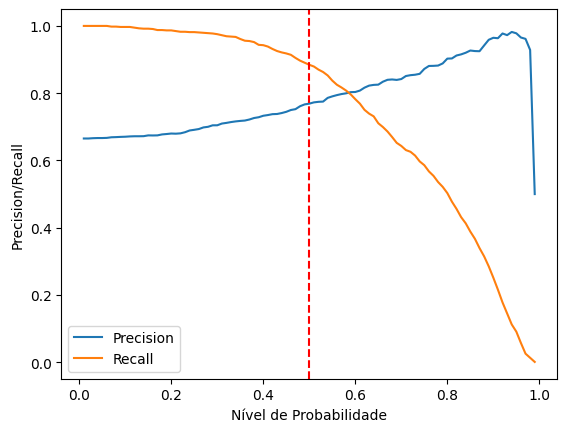

In [95]:
# plotar os dados
plt.plot(vetor_prob, precision, label='Precision')
plt.plot(vetor_prob, recall, label='Recall')
plt.xlabel('Nível de Probabilidade')
plt.ylabel('Precision/Recall')
plt.axvline(x=0.5, color='r', linestyle='--')
plt.legend()
plt.show()

A figura anterior mostra que as métricas *recall* e *precision* se relacionam de forma inversa: quando uma métrica aumenta, a outra diminui. Como no presente trabalho não há razão para se preferir a melhoria de uma das métricas em detrimento da outra, conforme citado anteriormente, definiu-se que o *threshold* ótimo de probabilidade é quando as curvas de *recall* e *precision* se cruzam (possuem valores iguais), o que, pela figura, não ocorre no *threshold* padrão de probabilidade (50%) (linha vermelha pontilhada) usado anteriormente para classificar o vinho como 0 (zero) ou 1 (um).

O código abaixo irá identificar o valor do *threshold* que iguala os valores de *recall* e de *precision*.

In [96]:
# nível de tolerância em que os dois são iguais
tolerancia = 1e-2

# encontrar o índice no qual as métricas recall e precision são iguais
iguais_index = [i for i in range(len(precision)) if math.isclose(precision[i], recall[i], rel_tol=tolerancia)]

# encontrar a probabilidade associada ao índex
prob_otima = vetor_prob[iguais_index]

prob_otima[0]

0.59

Portanto, o *threshold* ótimo de probabilidade, ao se conferir a mesma importância para *recall* e *precision* deve ser de 59%, ao invés de 50%. O código a seguir irá classificar novamente os exemplos do banco de dados de teste usando este novo *threshold*.

In [97]:
# novo threshold
threshold = 0.59

# novas projecoes
yhat_reg_log1_nova = [1 if prob_test[i][1] >= threshold else 0 for i in range(len(prob_test))]

Por sua vez, o próximo código calcula as métricas do modelo para as projeções realizadas com o novo *threshold*. Percebe-se que houve pequena melhora na média ponderada do *f1-score* (de 0.73 para 0.74).

In [98]:
# métricas do modelo
print(classification_report(y_test, yhat_reg_log1_nova))

              precision    recall  f1-score   support

           0       0.60      0.61      0.61       492
           1       0.80      0.80      0.80       978

    accuracy                           0.73      1470
   macro avg       0.70      0.70      0.70      1470
weighted avg       0.74      0.73      0.74      1470



A figura a seguir mostra a curva ROC gerada pelo modelo escolhido anteriormente.

**Figura 3 - Curva ROC do modelo final de regressão logística**

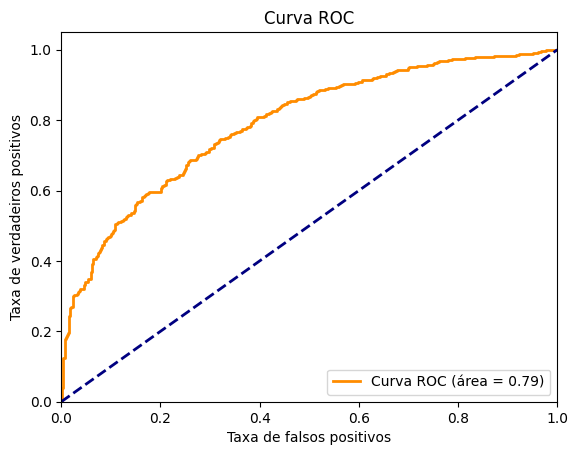

In [99]:
# calcular a curva ROC e o AUC
fpr, tpr, thresholds = roc_curve(y_test, prob_test[:,1])
roc_auc = auc(fpr, tpr)

# plotar a curva roc
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**c. Treinar um modelo de árvore de decisão**

Na sequência, a fim de se verificar o modelo que possui o melhor desempenho para projeção da variável *target* do banco de dados de vinhos brancos, foi treinado um modelo de árvore de decisão.

Para definir o valor dos hiperparâmetros do modelo, foi utilizado o mesmo algoritmo aplica na regressão logística, com a pesquisa aleatória seguida da pesquisa bruta. Os hiperparâmetros pesquisados foram:
- a profundida máxima da árvore (*max_depth*), cuja busca compreendeu o intervalo de 1 a 19;
- o *'class_weight'*, que é possui a mesma função do hiperparâmetro da regressão logística. Os valores de busca foram *'balanced'* e *None*;
- o critério para mensurar a qualidade da divisão dos dados (*criterion*), que avaliou os critérios *gini*, *entropy* e *log_loss*; e  
- a quantidade de *features* que deve ser avaliada (*k*), com valores de 1 a 12.

Além disso, foi realizada validação cruzada estratificada com 10 folhas utilizando a mesma divisão dos dados adotada no modelo de regressão logística. O código a seguir realiza a identificação dos melhores hiperparâmetros pela pesquisa aleatória.

In [230]:
# criar um pipeline
dt1 = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('model', DecisionTreeClassifier(random_state=1))
])

# definir o intervalo de busca
params_grid_ad = {
    'model__max_depth': range(1, 20),
    'model__class_weight': ['balanced',None],
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'selector__k': range(1,13)
}

# criar o buscador aleatório
busca_ad = RandomizedSearchCV(
    estimator=dt1,
    param_distributions=params_grid_ad,
    n_iter=200,
    cv=divisor,
    scoring=scorers,
    refit='f1_score',
    error_score=0
)

# criar o modelo de árvore de decisão
busca_ad.fit(x_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
                   error_score=0,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('selector', SelectKBest()),
                                             ('model',
                                              DecisionTreeClassifier(random_state=1))]),
                   n_iter=200,
                   param_distributions={'model__class_weight': ['balanced',
                                                                None],
                                        'model__criterion': ['gini', 'entropy',
                                                             'log_loss'],
                                        'mode...
                                        'selector__k': range(1, 13)},
                   refit='f1_score',
                   scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                            'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                            'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                            'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

O código a seguir mostra os melhores hiperparâmetros identificados pela busca aleatória.

In [231]:
busca_ad.best_params_

{'selector__k': 11,
 'model__max_depth': 12,
 'model__criterion': 'gini',
 'model__class_weight': None}

Para a pesquisa bruta, optou-se por remover o hiperparâmetro *class_weight* e ajustar o intervalo de busca de *k* para 6 a 12.

In [187]:
# definir o intervalo de busca
params_grid_ad2 = {
    'model__max_depth': range(1, 20),
    'model__criterion': ['gini', 'entropy', 'log_loss'],
    'selector__k': range(6,13)
}

# criar o buscador
busca_ad2 = GridSearchCV(
    estimator=dt1,
    param_grid=params_grid_ad2,
    cv=divisor,
    scoring=scorers,
    refit='f1_score',
    error_score=0
)

# criar o modelo de árvore de decisão
busca_ad2.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('selector', SelectKBest()),
                                       ('model',
                                        DecisionTreeClassifier(random_state=1))]),
             param_grid={'model__criterion': ['gini', 'entropy', 'log_loss'],
                         'model__max_depth': range(1, 20),
                         'selector__k': range(6, 13)},
             refit='f1_score',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

O código a seguir apresenta os melhores hiperparâmetros identificados pela pesquisa bruta.

In [188]:
busca_ad2.best_params_

{'model__criterion': 'gini', 'model__max_depth': 13, 'selector__k': 11}

A tabela a seguir mostra a média e o desvio padrão de cada métrica de performance do melhor modelo estimado pela validação cruzada

In [189]:
# identificar os melhores hiperparâmetros
best_index_ad = busca_ad2.best_index_

# capturar a média do modelo com os melhores hiperparâmetros
mean_test_accuracy_ad = busca_ad2.cv_results_['mean_test_accuracy'][best_index_ad]
mean_test_recall_ad = busca_ad2.cv_results_['mean_test_recall'][best_index_ad]
mean_test_precision_ad = busca_ad2.cv_results_['mean_test_precision'][best_index_ad]
mean_test_f1_score_ad = busca_ad2.cv_results_['mean_test_f1_score'][best_index_ad]

# capturar o desvio padrão do modelo com os melhores hiperparâmetros
sd_test_accuracy_ad = busca_ad2.cv_results_['std_test_accuracy'][best_index_ad]
sd_test_recall_ad = busca_ad2.cv_results_['std_test_recall'][best_index_ad]
sd_test_precision_ad = busca_ad2.cv_results_['std_test_precision'][best_index_ad]
sd_test_f1_score_ad = busca_ad2.cv_results_['std_test_f1_score'][best_index_ad]

# gerar DataFrame
ad_metrics = pd.DataFrame({
    'Métricas': ['accuracy', 'recall', 'precision', 'f1_score'],
    'Média': [mean_test_accuracy_ad, mean_test_recall_ad, mean_test_precision_ad, mean_test_f1_score_ad],
    'Desvio padrão': [sd_test_accuracy_ad, sd_test_recall_ad, sd_test_precision_ad, sd_test_f1_score_ad]
})

**Tabela 6 - Média e desvio padrão das métricas de performance geradas na validação cruzada da árvore de decisão**

In [190]:
ad_metrics

Métricas     Média  Desvio padrão
0   accuracy  0.774807       0.021427
1     recall  0.774807       0.021427
2  precision  0.774730       0.020964
3   f1_score  0.774494       0.021116

O próximo código apresenta as métricas de performance para os dados de teste do modelo que possui os melhores hiperparâmetros.

In [191]:
# selecionar o modelo com os melhores hiperparâmetros
yhat_ad = busca_ad2.best_estimator_.predict(x_test)

# mostrar as métricas de performance
print(classification_report(y_test, yhat_ad))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       492
           1       0.82      0.84      0.83       978

    accuracy                           0.77      1470
   macro avg       0.74      0.73      0.74      1470
weighted avg       0.77      0.77      0.77      1470



A semelhança entre os valores médios das métricas da Tabela 6 e as médias ponderadas usando os dados de teste (valores anteriores) indicam baixa chance de que tenha ocorrido *overfitting*. Além disso, o valor do F1 score ponderado calculado com a base de teste (0.77) é superior ao valor do modelo *baseline* (0.53).

  A Figura 4 mostra a curva ROC do modelo de árvore de decisão com os melhores hiperparâmetros.

**Figura 4 - Curva ROC do modelo final de árvore de decisão**

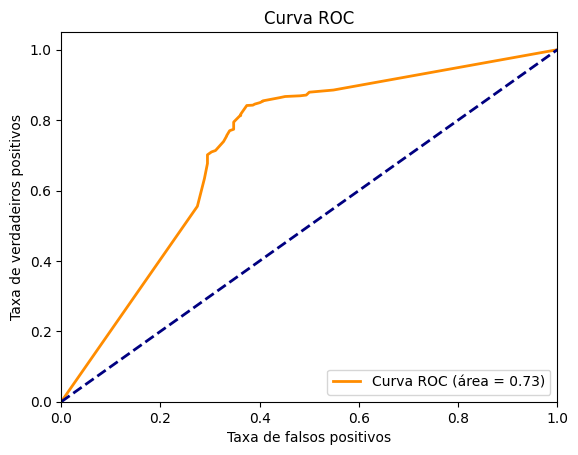

In [192]:
# calcular as probabilidades
y_prob = busca_ad2.best_estimator_.predict_proba(x_test)

# calcular a curva ROC e o AUC
fpr_ad, tpr_ad, thresholds_ad = roc_curve(y_test, y_prob[:,1])
roc_auc_ad = auc(fpr_ad, tpr_ad)

# plotar a curva roc
plt.figure()
plt.plot(fpr_ad, tpr_ad, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc_ad)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

**d. Treinar um modelo SVM**

Por fim, foi treinado um modelo SVM a fim de avaliar a sua performance em comparação com a regressão logística e a árvore de decisão. A pesquisa de hiperparâmetros foi realizada seguindo o mesmo algoritmo utilizado nos modelos anteriores. Na primeira tentativa, os hiperparâmetros avaliados foram:  
- *'C'*, que controla da força da regularização. O intervalo de valores é o mesmo da regressão logística;
- *'kernel'*, o qual especifica o tipo de *kernel* usado pelo algoritmo. O *kernel* é uma função usada para transformar os dados em um espaço dimensional maior. Os valores avaliados foram 'linear', 'poly', 'rbf' e 'sigmoid';  
- *'degree'*, que o grau do polinômio da função *kernel*. Os valores avaliados foram 1, 2 e 3; e  
- *'k'*, que é quantidade de *features* no modelo. Os valores avaliados foram de 6 a 12.

Contudo, depois de mais de 20 minutos pesquisando os hiperparâmetros citados, a pesquisa ainda estava sendo executada. Deste modo, optou-se por restringir o intervalo de busca de alguns hiperparâmetros, mas ainda sem sucesso. O processo só foi finalizado em um tempo razoável quando foram eliminados das pesquisa os hiperparâmetros *'C'* e *'kernel'*. Portanto, a pesquisa foi realizada apenas para os hiperparâmetros *'degree'* e *'k'*. Com a quantidade menor de hiperparâmetros, foi realizada a pesquisa bruta de forma direta.

O código a seguir realiza a pesquisa dos hiperparâmetros e também a validação cruzada com 10 folhas usando a mesma divisão dos dados utilizada nos modelos anteriores.

In [193]:
# criar um pipeline
svm1 = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif)),
    ('model', SVC(random_state=1))
])

# definir o intervalo de busca
params_grid_svm = {
    'model__degree': [1, 2, 3],
    'selector__k': range(6,13)
}

busca_svm = GridSearchCV(
    estimator=svm1,
    param_grid=params_grid_svm,
    cv=divisor,
    scoring=scorers,
    refit='f1_score',
    error_score=0
)

# criar o modelo de árvore de decisão
busca_svm.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=10, shuffle=True),
             error_score=0,
             estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('selector', SelectKBest()),
                                       ('model', SVC(random_state=1))]),
             param_grid={'model__degree': [1, 2, 3],
                         'selector__k': range(6, 13)},
             refit='f1_score',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1_score': make_scorer(f1_score, response_method='predict', average=weighted),
                      'precision': make_scorer(precision_score, response_method='predict', average=weighted),
                      'recall': make_scorer(recall_score, response_method='predict', average=weighted)})

O código a seguir mostra os melhores hiperparâmetros identificados pelo modelo.

In [194]:
# melhores hiperparâmetros
busca_svm.best_params_

{'model__degree': 1, 'selector__k': 11}

A tabela a seguir mostra a média e o desvio padrão de cada métrica de performance do melhor modelo estimado pela validação cruzada

In [232]:
# identificar os melhores hiperparâmetros
best_index_svm = busca_svm.best_index_

# capturar a média do modelo com os melhores hiperparâmetros
mean_test_accuracy_svm = busca_svm.cv_results_['mean_test_accuracy'][best_index_svm]
mean_test_recall_svm = busca_svm.cv_results_['mean_test_recall'][best_index_svm]
mean_test_precision_svm = busca_svm.cv_results_['mean_test_precision'][best_index_svm]
mean_test_f1_score_svm = busca_svm.cv_results_['mean_test_f1_score'][best_index_svm]

# capturar o desvio padrão do modelo com os melhores hiperparâmetros
sd_test_accuracy_svm = busca_svm.cv_results_['std_test_accuracy'][best_index_svm]
sd_test_recall_svm = busca_svm.cv_results_['std_test_recall'][best_index_svm]
sd_test_precision_svm = busca_svm.cv_results_['std_test_precision'][best_index_svm]
sd_test_f1_score_svm = busca_svm.cv_results_['std_test_f1_score'][best_index_svm]

# gerar DataFrame
svm_metrics = pd.DataFrame({
    'Métricas': ['accuracy', 'recall', 'precision', 'f1_score'],
    'Média': [mean_test_accuracy_svm, mean_test_recall_svm, mean_test_precision_svm, mean_test_f1_score_svm],
    'Desvio padrão': [sd_test_accuracy_svm, sd_test_recall_svm, sd_test_precision_svm, sd_test_f1_score_svm]
})

**Tabela 7 - Média e desvio padrão das métricas de performance geradas na validação cruzada do SVM**

In [233]:
svm_metrics

Métricas     Média  Desvio padrão
0   accuracy  0.778588       0.025091
1     recall  0.778588       0.025091
2  precision  0.773192       0.026625
3   f1_score  0.773511       0.026162

O código a seguir apresenta as métricas de performance para os dados de teste do modelo que possui os melhores hiperparâmetros.

In [197]:
# selecionar o modelo com os melhores hiperparâmetros
yhat_svm = busca_svm.best_estimator_.predict(x_test)

# mostrar as métricas de performance
print(classification_report(y_test, yhat_svm))

              precision    recall  f1-score   support

           0       0.69      0.56      0.62       492
           1       0.80      0.88      0.83       978

    accuracy                           0.77      1470
   macro avg       0.75      0.72      0.73      1470
weighted avg       0.76      0.77      0.76      1470



A semelhança entre os valores médios das métricas da Tabela 7 e as médias ponderadas usando os dados de teste (valores anteriores) indicam baixa chance de ter ocorrido *overfitting*.

Em razão de não ter sido possível testar alguns hiperparâmetros em um tempo razoável, como citado anteriormente, alguns deles foram testados manualmente, como o *C* e o *kernel*. Os melhores resultados, em termos de *f1-score*, foi a alteração do C para 5. O código abaixo estima o novo modelo.

In [221]:
# criar um pipeline
svm2 = Pipeline([
    ('scaler', RobustScaler()),
    ('selector', SelectKBest(f_classif, k=11)),
    ('model', SVC(random_state=2, C=5, degree=1, probability=True))
])

svm2.fit(x_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()), ('selector', SelectKBest(k=11)),
                ('model',
                 SVC(C=5, degree=1, probability=True, random_state=2))])

Os códigos a seguir mostram as métricas de performance do novo modelo para os dados de treinamento e de teste, respectivamente. Há pequena diferença entre as métricas dos dados de treinamento e de teste, o que indica baixa chance ter ocorrido *overfitting*. Houve melhora no F1 score ponderado em relação ao modelo anterior (0.78 ante 0.76), valor este também superior ao do modelo *baseline* (0.53).

In [222]:
# realizar a classificação das dados de treinamento
ytrain_svm2 = svm2.predict(x_train)

# mostrar as métricas de performance
print(classification_report(y_train, ytrain_svm2))

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      1148
           1       0.86      0.91      0.88      2280

    accuracy                           0.84      3428
   macro avg       0.83      0.81      0.82      3428
weighted avg       0.84      0.84      0.84      3428



In [223]:
# realizar a classificação para dados de teste
yhat_svm2 = svm2.predict(x_test)

# mostrar as métricas de performance
print(classification_report(y_test, yhat_svm2))

              precision    recall  f1-score   support

           0       0.70      0.61      0.65       492
           1       0.82      0.87      0.84       978

    accuracy                           0.78      1470
   macro avg       0.76      0.74      0.75      1470
weighted avg       0.78      0.78      0.78      1470



A figura a seguir mostra a curva ROC para o modelo anterior.

**Figura 5 - Curva ROC do modelo final de SVM**

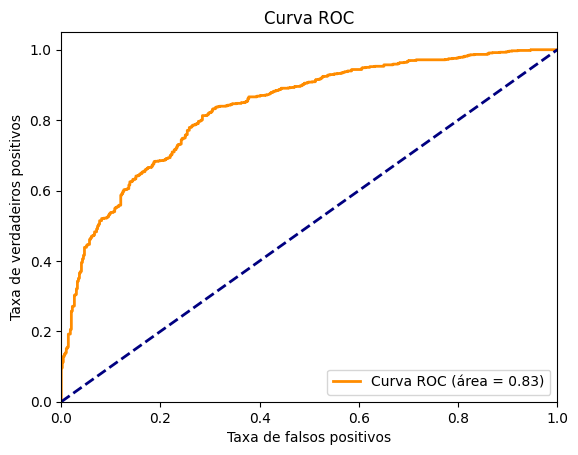

In [224]:
# calcular as probabilidades
y_prob = svm2.predict_proba(x_test)

# calcular a curva ROC e o AUC
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

# plotar a curva roc
plt.figure()
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc_svm)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de falsos positivos')
plt.ylabel('Taxa de verdadeiros positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

#### **5. Escolha do melhor modelo**

Como explicado anteriormente, as métricas escolhidas para avaliação da performance dos modelos foram o F1 score e a área sob a curva ROC. Isto posto, o modelo escolhido para entrar em operação seria o SVM. A escolha do mesmo reside no fato de que ele apresentou o maior valor de F1 Score ponderado do que os outros modelos para os dados de teste (0.78) e apresentou a maior área sob a curva ROC (0.83).

Apesar de o modelo de Árvore de Decisão ter apresentado o menor desvio padrão para o F1 score durante a validação cruzada, ele apresentou performance ligeiramente inferior no F1 score dos dados de teste e a sua área sob a curva ROC foi sensivelmente inferior à área do modelo SVM, o que justifica ele ter sido preterido.

Por fim, o modelo de regressão logística também apresentou menor desvio padrão para o F1 score durante a validação cruzada, na comparação com o SVM, mas teve performance inferior no F1 score ponderado dos dados de teste e na área sob a curva ROC, também justificando não ter sido escolhido.

#### **6. Utilizar o modelo escolhido para classificar os vinhos tintos**

O código a seguir faz a importação dos dados de vinhos tintos.

In [182]:
# nome do arquivo de vinho branco
wine_red = "winequality/winequality-red.csv"

# baixar o arquivo ZIP
urllib.request.urlretrieve(url, zip_arq)

# extrair o CSV de dentro do arquivo ZIP
with zipfile.ZipFile(zip_arq, 'r') as zip_ref:
    zip_ref.extract(wine_red)

# carregar o arquivo
red = pd.read_csv(wine_red, sep=";")

Em sequência, é gerada uma tabela com a descrição das variáveis presentes na base.

In [183]:
# extrair os nomes das colunas e converter em lista
red_var = red.columns.tolist()

# criar um dataframe de nomes
red_var_df = pd.DataFrame(red_var, columns=["Nome das variáveis"])

# capturar os tipos das variáveis e transformar em lista
red_type = red.dtypes.tolist()

# inserir no dataframe
red_var_df["Tipo"] = red_type

# calcular a media das variaveis
red_mean = red.mean().tolist()

# inserir no dataframe
red_var_df["Média"] = red_mean

# calcular o desvio padrão das variáveis
red_std = red.std().tolist()

# inserir no dataframe
red_var_df["Desvio padrão"] = red_std

# verificar se há missing values
red_missing = red.isnull().sum().tolist()

# inserir no dataframe
red_var_df["Nr. de missing values"] = red_missing

# contar a quantidade de observações
red_count = red.count().tolist()

# inserir no dataframe
red_var_df["Nr. de observações"] = red_count

**Tabela 8 - Descrição das variáveis da tabela de vinhos tintos**

In [184]:
red_var_df

Nome das variáveis     Tipo  ...  Nr. de missing values  Nr. de observações
0          fixed acidity  float64  ...                      0                1599
1       volatile acidity  float64  ...                      0                1599
2            citric acid  float64  ...                      0                1599
3         residual sugar  float64  ...                      0                1599
4              chlorides  float64  ...                      0                1599
5    free sulfur dioxide  float64  ...                      0                1599
6   total sulfur dioxide  float64  ...                      0                1599
7                density  float64  ...                      0                1599
8                     pH  float64  ...                      0                1599
9              sulphates  float64  ...                      0                1599
10               alcohol  float64  ...                      0                1599
11               quality    int64  ...                      0                1599

[12 rows x 6 columns]

Percebe-se que todas as variáveis possuem valores numéricos, não há valores faltando e os nomes das variáveis são os mesmos encontrados na base de vinhos brancos. O código a seguir substitui os espaços nos nomes das variáveis por *underline* (_).

In [225]:
# substituir o nome das variáveis por underline
red.columns = red.columns.str.replace(" ","_")

O código a seguir cria a variável "target" do modelo de classificação, chamada "opinion", de forma similar ao realizado na base vinho banco.

In [226]:
# criar a variável target "opinion"
red['opinion'] = red['quality'].apply(lambda x: 0 if x <= 5 else 1)

# eliminar a variável 'quality' da base
red.drop('quality', axis=1, inplace=True)

O código a seguir cria bases separadas de variáveis explicativas e da variável *target* para serem usadas na classificação.

In [228]:
# criar a base de variáveis explicativas
x_red = red.drop('opinion', axis=1)

# criar a base da variável target
y_red = red['opinion']

A seguir, foi aplicado o modelo SVM escolhido anteriormente nas variáveis de vinho tinto, a fim de se verificar a sua performance.

In [229]:
# realizar a classificação
yhat_red = svm2.predict(x_red)

# mostrar as métricas de performance
print(classification_report(y_red, yhat_red))

              precision    recall  f1-score   support

           0       0.50      0.95      0.66       744
           1       0.80      0.17      0.28       855

    accuracy                           0.53      1599
   macro avg       0.65      0.56      0.47      1599
weighted avg       0.66      0.53      0.46      1599



O resultado da classificação dos vinhos tintos foi bem abaixo do resultado obtido na amostra de teste dos vinhos brancos. A explicação para isso reside, principalmente, na diferença entre os tipos de vinhos. Apesar de a classificação dos vinhos tintos usar o mesmo modelo, com as mesmas variáveis explicativas, do modelo de vinhos brancos, a relação entre as variáveis explicativas a variável *target* deve ser diferente entre os dois vinhos, o que não foi capturado pelos parâmetros do modelo, em razão de ele ter sido treinado apenas com dados de vinhos brancos.